In [1]:
# Import necessary libraries
import os
import torch
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from dataset import FaceDataset  # Your existing dataset class
from config_loader import load_config  # Your config loader

[Dataset Initialization - train] Loaded 976 images with faces
Loaded 976 samples for analysis
Collected 1318 bounding boxes


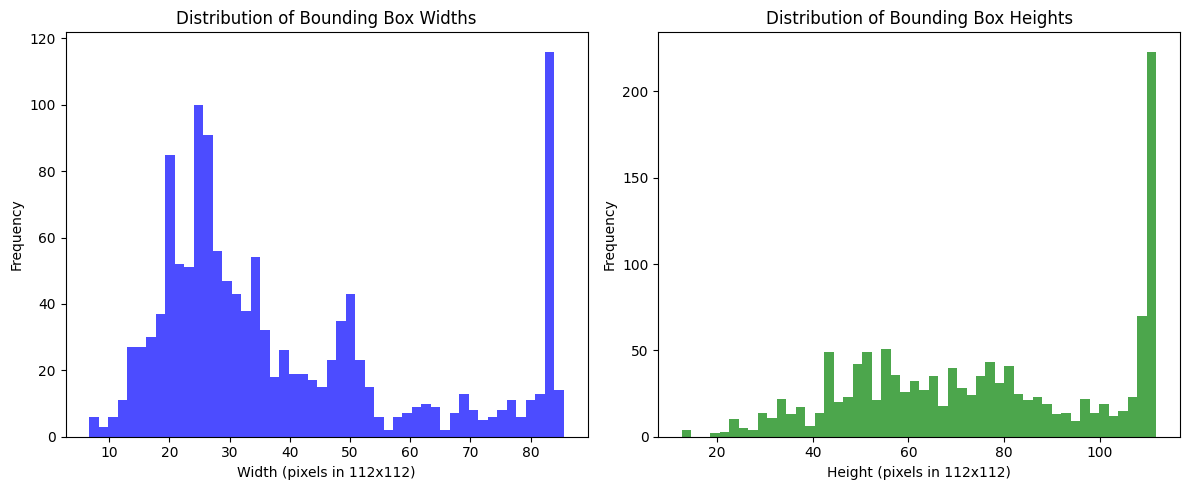

Width Statistics:
Mean: 39.25, Median: 31.63
10th percentile: 18.90, 90th percentile: 82.19
Height Statistics:
Mean: 75.64, Median: 74.74
10th percentile: 42.62, 90th percentile: 110.91
Suggested anchor sizes based on width percentiles: [23, 31, 49]

MobileFaceNet (Feature Map: 4x4, Stride: 28.0):
Adjusted anchor sizes: [23, 31, 49]

YOLOTinyFaceNet (Feature Map: 7x7, Stride: 16.0):
Adjusted anchor sizes: [23, 31, 32.0]

EfficientFaceNet (Feature Map: 14x14, Stride: 8.0):
Adjusted anchor sizes: [16.0, 16.0, 16.0]


In [2]:
# Load config
config = load_config("face_config.yaml")
dataset_dir = config["paths"]["dataset_dir"]

# Initialize dataset (use train split for analysis)
train_dataset = FaceDataset(img_dir=dataset_dir, split='train')
print(f"Loaded {len(train_dataset)} samples for analysis")

# Extract bounding box sizes
widths = []
heights = []
for idx in range(len(train_dataset)):
    _, bboxes, original_size = train_dataset[idx]  # bboxes: [N, 4], original_size: (w, h)
    orig_w, orig_h = original_size
    scale_x = 112 / orig_w  # Normalize to 112x112
    scale_y = 112 / orig_h
    for box in bboxes:
        x, y, w, h = box
        scaled_w = w * scale_x
        scaled_h = h * scale_y
        widths.append(scaled_w.item())
        heights.append(scaled_h.item())

widths = np.array(widths)
heights = np.array(heights)
print(f"Collected {len(widths)} bounding boxes")

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(widths, bins=50, color='blue', alpha=0.7)
plt.title("Distribution of Bounding Box Widths")
plt.xlabel("Width (pixels in 112x112)")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(heights, bins=50, color='green', alpha=0.7)
plt.title("Distribution of Bounding Box Heights")
plt.xlabel("Height (pixels in 112x112)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

# Compute statistics
print("Width Statistics:")
print(f"Mean: {np.mean(widths):.2f}, Median: {np.median(widths):.2f}")
print(f"10th percentile: {np.percentile(widths, 10):.2f}, 90th percentile: {np.percentile(widths, 90):.2f}")

print("Height Statistics:")
print(f"Mean: {np.mean(heights):.2f}, Median: {np.median(heights):.2f}")
print(f"10th percentile: {np.percentile(heights, 10):.2f}, 90th percentile: {np.percentile(heights, 90):.2f}")

# Suggest anchor sizes based on percentiles
anchor_sizes = [
    int(np.percentile(widths, 25)),  # Small anchor
    int(np.median(widths)),         # Medium anchor
    int(np.percentile(widths, 75))  # Large anchor
]
print(f"Suggested anchor sizes based on width percentiles: {anchor_sizes}")

# Adjust for each model's feature map resolution
models = {
    "MobileFaceNet": (4, 4),
    "YOLOTinyFaceNet": (7, 7),
    "EfficientFaceNet": (14, 14)
}

for model_name, (H, W) in models.items():
    stride = 112 / H  # Same for H and W since 112x112 is square
    print(f"\n{model_name} (Feature Map: {H}x{W}, Stride: {stride:.1f}):")
    adjusted_anchors = [max(stride / 2, min(size, stride * 2)) for size in anchor_sizes]
    print(f"Adjusted anchor sizes: {adjusted_anchors}")

Step 1: Interpret the Histograms and Statistics
Bounding Box Widths
Histogram: The distribution of widths is right-skewed, with a peak around 20–40 pixels and a long tail extending to 80 pixels.
Statistics:
Mean: 39.25
Median: 31.63
10th percentile: 18.90
90th percentile: 82.19
Suggested Anchor Sizes (based on width percentiles): [23, 31, 49] (25th, 50th, 75th percentiles)
Bounding Box Heights
Histogram: The distribution of heights is also right-skewed, with a peak around 60–80 pixels and a tail extending to 110 pixels.
Statistics:
Mean: 75.64
Median: 74.74
10th percentile: 42.62
90th percentile: 110.91
Key Observation: Aspect Ratio
The bounding boxes are not square:
Median width: 31.63
Median height: 74.74
Aspect ratio (height/width): ~2.36 (taller than wide)
This suggests that faces/bodies in your surgical videos are often vertically elongated (e.g., capturing a person’s face and upper body). The current anchor generation assumes square boxes (size, size), which may lead to poor matching with ground truth boxes.
Current Suggested Anchor Sizes
Based on width percentiles: [23, 31, 49]
Adjusted for each model:
MobileFaceNet (stride 28): [23, 31, 49]
YOLOTinyFaceNet (stride 16): [23, 31, 32]
EfficientFaceNet (stride 8): [16, 16, 16]
Issues with Current Anchor Sizes
Aspect Ratio Ignored: The anchors are square, but your boxes have a height/width ratio of ~2.36. This mismatch can reduce IoU during training, leading to poor detection performance.
EfficientFaceNet Anchors: [16, 16, 16] is problematic—having all anchors the same size defeats the purpose of multi-scale detection. This happened because the adjustment logic capped sizes too aggressively (e.g., min(size, stride * 2)).
Long Tail in Distribution: The 90th percentile for widths (82.19) and heights (110.91) indicates some large boxes. The current anchors may not adequately cover these larger objects, especially for models with coarser feature maps (e.g., MobileFaceNet).
Step 2: Adjust Anchor Sizes with Aspect Ratios
To address these issues, we’ll:

Incorporate aspect ratios into anchor generation.
Recompute anchor sizes to better cover the range of box sizes.
Ensure anchors are appropriate for each model’s feature map resolution.
2.1: Define Anchor Sizes and Aspect Ratios
Instead of using only width percentiles, let’s consider both width and height distributions and introduce aspect ratios.

Anchor Sizes: Use the 25th, 50th, and 75th percentiles of the smaller dimension (width, since it’s smaller) to define base sizes, then adjust for height using the aspect ratio.
Width percentiles: [23, 31, 49]
For larger boxes (to cover the 90th percentile), we can add a larger size closer to the 90th percentile of width (82.19), but scaled appropriately per model.
Aspect Ratios: Since the median height/width ratio is ~2.36, we’ll use aspect ratios like [1:1, 2:1, 1:2] to capture square, tall, and wide boxes.
Let’s redefine the base anchor sizes (based on width):

Small: 23 (25th percentile)
Medium: 31 (50th percentile)
Large: 49 (75th percentile)
Extra Large: 70 (closer to 90th percentile, but not too large for smaller feature maps)